In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Grabs the first date in the query as a starting point
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2618533c0a0>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0}

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recentDate = first_row.date

# Loop through the query results for the most recent date
for row in session.query(measurement.date).all():
    currentDate = row.date
    if currentDate > recentDate:
        recentDate = currentDate

recentDate

'2017-08-23'

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
yearPrior = str(dt.date(int(recentDate[:4]), int(recentDate[5:7]), int(recentDate[-2:])) - dt.timedelta(days=365))

# Perform a query to retrieve the data and precipitation scores
for row in engine.execute(f'SELECT * FROM measurement WHERE date > "{yearPrior}" LIMIT 10').fetchall():
    print(row)

(2365, 'USC00519397', '2016-08-24', 0.08, 79.0)
(2366, 'USC00519397', '2016-08-25', 0.08, 80.0)
(2367, 'USC00519397', '2016-08-26', 0.0, 79.0)
(2368, 'USC00519397', '2016-08-27', 0.0, 77.0)
(2369, 'USC00519397', '2016-08-28', 0.01, 78.0)
(2370, 'USC00519397', '2016-08-29', 0.0, 78.0)
(2371, 'USC00519397', '2016-08-30', 0.0, 79.0)
(2372, 'USC00519397', '2016-08-31', 0.13, 80.0)
(2373, 'USC00519397', '2016-09-01', 0.0, 81.0)
(2374, 'USC00519397', '2016-09-02', 0.0, 80.0)


In [11]:
# Save the query results as a Pandas DataFrame and set the index to the date column
sqlDF = pd.read_sql(
    f'SELECT date,prcp FROM measurement WHERE date > "{yearPrior}"',
    con=engine,
)

sqlDF = sqlDF.set_index('date') # Sets date as index column
sqlDF = sqlDF.sort_values(by='date') # Sort the dataframe by date
sqlDF = sqlDF.dropna() # Drops rows with NA values
sqlDF

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


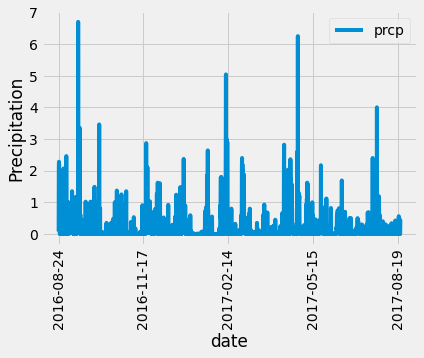

In [25]:
# Use Pandas Plotting with Matplotlib to plot the data
sqlDF.plot(y='prcp')
plt.xticks(rotation=90)
plt.ylabel("Precipitation")
plt.show()
#plt.savefig("Images/PreciptationByDateInPreviou.png")

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary = sqlDF.agg(['count','mean', 'std', 'min','max'])
summary = summary.rename(columns={'prcp':'Precipitation'})

# Calculates percentiles and adds it to the dataframe results
summary.loc['25%'] = [np.percentile(sqlDF['prcp'].tolist(),25)]
summary.loc['50%'] = [np.percentile(sqlDF['prcp'].tolist(),50)]
summary.loc['75%'] = [np.percentile(sqlDF['prcp'].tolist(),75)]
summary

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
max,6.700000
25%,0.000000
50%,0.020000
75%,0.130000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
for row in engine.execute(f'SELECT * FROM measurement WHERE date > "{yearPrior}" LIMIT 10').fetchall():
    print(row)

(2365, 'USC00519397', '2016-08-24', 0.08, 79.0)
(2366, 'USC00519397', '2016-08-25', 0.08, 80.0)
(2367, 'USC00519397', '2016-08-26', 0.0, 79.0)
(2368, 'USC00519397', '2016-08-27', 0.0, 77.0)
(2369, 'USC00519397', '2016-08-28', 0.01, 78.0)
(2370, 'USC00519397', '2016-08-29', 0.0, 78.0)
(2371, 'USC00519397', '2016-08-30', 0.0, 79.0)
(2372, 'USC00519397', '2016-08-31', 0.13, 80.0)
(2373, 'USC00519397', '2016-09-01', 0.0, 81.0)
(2374, 'USC00519397', '2016-09-02', 0.0, 80.0)


In [15]:
# Returns total number of unique stations from measurement table
numberStations = session.query(measurement.station).distinct().count()
numberStations

9

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activeStationQuery = session.query(measurement.station, func.count(measurement.station)). \
                        group_by(measurement.station). \
                        order_by(func.count(measurement.station).desc()). \
                        all()

# Takes the first station in the sorted list
mostActiveStation = activeStationQuery[0][0]
activeStationQuery

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
print(f"The most active station is {mostActiveStation}")

The most active station is USC00519281


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mostActiveStationQuery = session.query(func.min(measurement.tobs), \
                                       func.max(measurement.tobs), \
                                       func.avg(measurement.tobs)). \
                        filter_by(station=f'{mostActiveStation}').all()

mostActiveStationQuery
print(f"{mostActiveStation} Temperatures\nLowest: {mostActiveStationQuery[0][0]}\nHighest: {mostActiveStationQuery[0][1]}\nAverage: {round(mostActiveStationQuery[0][2],2)}")

USC00519281 Temperatures
Lowest: 54.0
Highest: 85.0
Average: 71.66


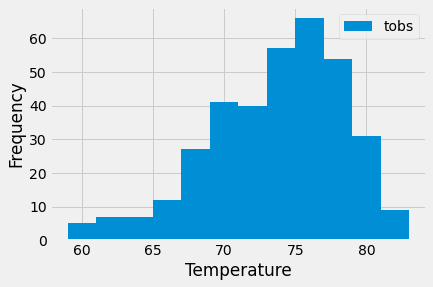

In [19]:
# Takes the date of the most active station in the first query result as a starting point.
firstRow = session.query(measurement).filter_by(station=f'{mostActiveStation}').first()
activeStationRecentDate = firstRow.date

# Loop through query results to identify the most recent date of the most active station
for row in session.query(measurement.date).filter_by(station=f'{mostActiveStation}').all():
    currentDate = row.date
    if currentDate > activeStationRecentDate:
        activeStationRecentDate = currentDate

# Calculates the year prior to the most recent date
activeStationYearPrior = str(dt.date(int(activeStationRecentDate[:4]), int(activeStationRecentDate[5:7]), int(activeStationRecentDate[-2:])) - dt.timedelta(days=365))

# Query to identify the temperatures of the most active station for 
# the previous year and populate the results into a dataframe
activeStationTempDF = pd.read_sql(
    f'SELECT date,tobs FROM measurement WHERE date > "{activeStationYearPrior}" AND station = "{mostActiveStation}"',
    con=engine,
)

# Plots results as histogram
activeStationTempDF.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.show()

# Test Code for Flask App
The cells of code below displays the logic of the queries used in the "/api/v1.0/start<start>" and "/api/v1.0/start<start>/end<end>" dynamic API routes.

In [20]:
# Displays all temperatures after the given date (inclusive)
date="2017-08-23"
results = session.query(measurement.date,measurement.tobs).\
            filter(measurement.date >= date).all()
results

[('2017-08-23', 81.0),
 ('2017-08-23', 82.0),
 ('2017-08-23', 82.0),
 ('2017-08-23', 76.0)]

In [21]:
# Calculates the min, max, and avg for the temperatures after the given date
date="2017-08-23"
results = session.query(func.min(measurement.tobs), \
                                       func.max(measurement.tobs), \
                                       func.avg(measurement.tobs)). \
                        filter(measurement.date >= date).all()
results

[(76.0, 82.0, 80.25)]

In [22]:
# Displays all temperatures between two dates (inclusive)
date="2016-08-23"
date2="2016-08-24"
results = session.query(measurement.date,measurement.tobs).\
            filter(measurement.date >= date,measurement.date <= date2).all()
results

[('2016-08-23', 81.0),
 ('2016-08-24', 79.0),
 ('2016-08-23', 76.0),
 ('2016-08-24', 76.0),
 ('2016-08-23', 80.0),
 ('2016-08-24', 80.0),
 ('2016-08-23', 80.0),
 ('2016-08-24', 78.0),
 ('2016-08-23', 80.0),
 ('2016-08-24', 79.0),
 ('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-23', 74.0),
 ('2016-08-24', 74.0)]

In [23]:
# Calculates the min, max, and avg for the temperatures between two dates
date="2017-08-23"
date2="2017-08-24"

results = session.query(func.min(measurement.tobs), \
                                       func.max(measurement.tobs), \
                                       func.avg(measurement.tobs)). \
                        filter(measurement.date >= date,measurement.date <= date2).all()
results

[(76.0, 82.0, 80.25)]

# Close session

In [24]:
# Close Session
session.close()